# Install Packages and import libraries

In [ ]:
# install spacy
!python -m spacy download en_core_web_lg

2023-06-23 09:09:42.209284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 09:09:45.622441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=34a85e69007b6fa3ebecfba21d710777d5ab381600d5808d5d9975fdaff4d8ba
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
# for data manipulation
import pandas as pd
import numpy as np
import os

# for scoring
import spacy
from collections import Counter

# for statistical analysis
import pingouin as pg
from scipy.stats import shapiro, levene, permutation_test
from statsmodels.stats.multitest import multipletests

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for analysis

Load your dataset: "sign_events_data_statements.csv"

In [ ]:
df = pd.read_csv('/content/sign_events_data_statements.csv', encoding = "UTF-8")
df.head()

,signevent,q1,q2,unid,id,outcome_class
0,My brothers wedding,My little brother is getting married next Satu...,My brother and Kate have a daughter who will b...,FU304384,1,t
1,Going to collect 2 new pet rabbits,I will be driving for 80-90 minutes across Lon...,I saw the as for them a week ago but was going...,jr125663,2,t
2,Getting dinner with my friend Shan and my boyf...,We were planning to get dinner somewhere near ...,I haven't seen Shan in a while and have been m...,xE150711,3,t
3,mountain bike ride with my boyfriend and daughter,We are going to cannock chase with the mountai...,We will be taking our trek and wonder mountain...,RA263881,4,t
4,I will be going to the cat cafe in Glasgow on ...,I will be getting up Tuesday morning to go int...,I have looked into the cat cafe to know that t...,RD298286,5,t


In [ ]:
df.shape

(1640, 6)

In [ ]:
df['q1'][0]

'My little brother is getting married next Saturday, we have always been close as we lost our parents when we were in our late teens. I am so proud of the man he has become and love him dearly. The wedding is taking in an old castle and has taken much planning. He has found a wonderful partner in Kate and its going to be the most magical day. We have family and friends coming from far and wide to celebrate and I am super excited. My two sons are page boys and my brothers little one is a flower girl. '

In [ ]:
df['q2'][0]

'My brother and Kate have a daughter who will be flower girl.'

In [ ]:
df.isna().sum()

signevent        0
q1               0
q2               0
unid             0
id               0
outcome_class    0
dtype: int64

# Text Preprocessing

**Preprocessing steps:**

Compute tokenization and remove punctuations and extra spaces to count the exact number of words.

In [ ]:
# Load Spacy's English language model
nlp = spacy.load("en_core_web_lg")

In [ ]:
docs = []

for doc in nlp.pipe(df['q1'], n_process=os.cpu_count()-1, disable = ['transformer']):
    docs.append(doc)

In [ ]:
# Define a function to tokenize text
def tokenize(doc):

    # Remove punctuation and double space:
    tokens = [token.text for token in doc if not (token.is_punct or token.is_space)]
    # Join tokens back into a string
    tokens = " ".join(tokens)
    return tokens.lower()

In [ ]:
# Apply the preprocessing pipeline using nlp.pipe
tokens = []

for doc in docs:
    tokens.append(tokenize(doc))

# Add the preprocessed text as a new column in the dataframe
df['tokens'] = tokens

In [ ]:
df['tokens'][0]

'my little brother is getting married next saturday we have always been close as we lost our parents when we were in our late teens i am so proud of the man he has become and love him dearly the wedding is taking in an old castle and has taken much planning he has found a wonderful partner in kate and its going to be the most magical day we have family and friends coming from far and wide to celebrate and i am super excited my two sons are page boys and my brothers little one is a flower girl'

In [ ]:
# Define a function to lemmatize content words
def preprocessed_text(doc):
    # Remove punctuation, double space, stop words and lemmatize text:
    clean_tokens = [token.lemma_ for token in doc if not (token.is_punct or token.is_space or token.is_stop)]
    # Join the cleaned tokens back into a string
    clean_text = " ".join(clean_tokens)
    return clean_text.lower()

In [ ]:
# Apply the preprocessing pipeline using nlp.pipe
clean_text = []

for doc in docs:
    clean_text.append(preprocessed_text(doc))

# Add the preprocessed text as a new column in the dataframe
df['clean_text'] = clean_text

In [ ]:
df['clean_text'][0]

'little brother getting marry saturday close lose parent late teen proud man love dearly wedding take old castle take planning find wonderful partner kate go magical day family friend come far wide celebrate super excited son page boy brother little flower girl'

# Min-Max number of words in Intentions

In [ ]:
# Number of words per intention:
word_counts = [len(text.split()) for text in df['tokens']]
df['word_counts'] = word_counts

In [ ]:
# Write a function to compute the statistics of number of words in a text.
# word_counts_vec should be a vector with the total number of tokens for each text.

def num_of_words_stat(word_counts_vec):

  # Split each story into words and count the number of words

  # Find the minimum and maximum number of words
  min_words = word_counts_vec.min()
  max_words = word_counts_vec.max()
  mean_words = word_counts_vec.mean()
  std_words = word_counts_vec.std()

  print(f"Minimum number of words: {min_words}")
  print(f"Maximum number of words: {max_words}")
  print(f"Average number of words: {mean_words}")
  print(f"Standard deviation number of words: {std_words}")

  return min_words, max_words, mean_words, std_words

In [ ]:
# Compute the minimum, maximum, average and std number of word for all the INTENTIONS
print('All intentions:')
print()
min, max, avg, std = num_of_words_stat(df['word_counts'])

All intentions:

Minimum number of words: 15
Maximum number of words: 251
Average number of words: 50.43963414634146
Standard deviation number of words: 30.106076686199398


In [ ]:
# Split the DataFrames based on the values in the "outcome_class" column
df_h = df[df['outcome_class'] == 't']
df_d = df[df['outcome_class'] == 'd']

In [ ]:
# Compute the minimum, maximum, average and std number of word for TRUE INTENTIONS
print('True intentions:')
print()
min_rec, max_rec, avg_rec, std_rec = num_of_words_stat(df_h['word_counts'])

True intentions:

Minimum number of words: 15
Maximum number of words: 206
Average number of words: 47.03831417624521
Standard deviation number of words: 28.36483293689557


In [ ]:
# Compute the minimum, maximum, average and std number of word for FALSE INTENTIONS
print('False intentions:')
print()
min_img, max_img, avg_img, std_img = num_of_words_stat(df_d['word_counts'])

False intentions:

Minimum number of words: 15
Maximum number of words: 251
Average number of words: 53.54725787631272
Standard deviation number of words: 31.30805515873576


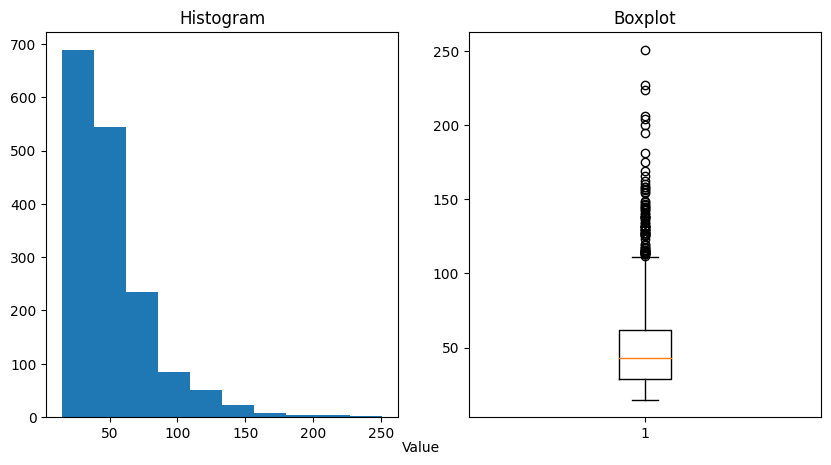

In [ ]:
# Explore the distribution of number of words
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the histogram on the first axis
ax1.hist(df['word_counts'], bins=10)
ax1.set_title('Histogram')

# plot the boxplot on the second axis
ax2.boxplot(df['word_counts'])
ax2.set_title('Boxplot')

# add a common x-axis label
fig.text(0.5, 0.04, 'Value', ha='center')

# show the plot
plt.show()


In [ ]:
# Let's check some story with the largest number of words
df[df['word_counts'] > avg + 2.5*std].sort_values('word_counts', ascending=True, inplace=False)

,signevent,q1,q2,unid,id,outcome_class,tokens,clean_text,word_counts
50,I am going to mentor a new start up,I am going to mentor a new start up run by a f...,I am a trained mentor. I belong to a social en...,mL146727,51,t,i am going to mentor a new start up run by a f...,go mentor new start run female entrepreneur ke...,126
1233,I have a pre-arranged basket ball game over th...,On saturday a few of my old school friends are...,You can view our old court at sale high school...,ZR815227,1234,d,on saturday a few of my old school friends are...,saturday old school friend get basketball game...,126
278,Visiting the Abraham Lincoln Presidential Libr...,As my oldest son has a strong interest in the ...,We have reservations for 2 rooms at the Hampto...,CR084061,279,t,as my oldest son has a strong interest in the ...,old son strong interest civil war plan road tr...,126
904,I will be going swimming with my daughter.,"My daughter Jane, aged 3, is very excited abou...",My daughter's swimming costume is yellow with ...,Bb989858,905,d,my daughter jane aged 3 is very excited about ...,daughter jane aged 3 excited going swim big po...,127
916,Going bowling with my family tomorrow morning,Everyone keeps telling me that I don't spend e...,"I'm not really sure how to prove that, to be h...",GZ394257,917,d,everyone keeps telling me that i do n't spend ...,keep tell spend time people brother especially...,127
1306,Going for a 5 mile social run then having a ba...,I will leave home just after 7am and meet up w...,That I know exactly how long 5 miles is. I hav...,ZX930458,1307,d,i will leave home just after 7 am and meet up ...,leave home 7 meet friend 7.30am local run club...,127
467,Hiking,This weekend I will go hiking in the hills aro...,I don't think there is any one bit of informat...,QP850409,468,t,this weekend i will go hiking in the hills aro...,weekend hike hill home town sure actual route ...,127
1170,I am attending a festival in Sheffield on Frid...,One of my friends is considering studying in S...,I have an 18-25 railcard which means I can get...,QW249699,1171,d,one of my friends is considering studying in s...,friend consider study sheffield university yea...,127
1486,I spend a few hours some nights watching episo...,Each week i have 2 days in which i dedicate to...,Tuesdays and Thursdays are the two days in a w...,da034571,1487,d,each week i have 2 days in which i dedicate to...,week 2 day dedicate take time work student 2 d...,129
417,playing a basketball game with my friends,So I have a basketball game on Saturday as par...,Playing with my friends is extremely important...,hb184272,418,t,so i have a basketball game on saturday as par...,basketball game saturday open age team consist...,129


In [ ]:
df.loc[1278,'q1']

"My friend Richard and I have decided to take a day trip to York on Saturday. We're thinking if get in about 11:30 and aim to leave at 8 that will give us enough time to see a lot of the city. We're going for lunch when we get in, I've heard a popular vegetarian restaurant El Piano is due to close soon so we're going to check that out. Then we're going for a wander - if it's sunny we'll walk the city walls as that's an easy way to take in the sights. We'll be drinking after that though - York has enough bars and pubs to visit a new one every day of the year! We'll probably start on Stonegate, at Evil Eye, as they do amazing cocktails. Then it's just a case of seeing where we fancy - there's no point going with much of a plan as York is very popular for Hen and Stag Do's, so it could be really busy. If we head home about 8 we think we can miss the Saturday night rush at least, and hopefully avoid much of a hangover the next day! "

In [ ]:
df.to_csv('preprocessed_sign_events_data_statements.csv', index = False)

# Linguistic Features Extraction:

## TEXTSTAT

TEXTSTAT is a Python package that provides a variety of text statistics, including readability scores and other metrics. Here's an example of how to use textstat to compute summary statistics for a text:

This code computes several summary statistics for the text variable:


1.   The number of sentences is computed using the sentence_count function from textstat.
2. The number of words is computed using the lexicon_count function.
3. The number of syllables is computed using the syllable_count function.
4. The average number of syllables per word is computed by dividing the total number of syllables by the total number of words.
5. The Flesch-Kincaid Grade Level is computed using the flesch_kincaid_grade function.





In [ ]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00


In [ ]:
import textstat

text_stats_df = pd.DataFrame()

for text in df['q1']:
  # Compute the number of sentences
  num_sentences = textstat.sentence_count(text)
  # Compute the number of words
  num_words = textstat.lexicon_count(text)
  # Compute the number of syllables
  num_syllables = textstat.syllable_count(text)
  # Compute the average number of syllables per word
  avg_syllables_per_word = num_syllables / num_words
  # Compute the Flesch-Kincaid Grade Level (focus on sentence length)
  fk_grade = textstat.flesch_kincaid_grade(text)
  # Compute the Flesch-Kincaid Grade Level (focus on syllables length)
  fk_read = textstat.flesch_reading_ease(text)

  # Create a dictionary with the computed values
  text_stats_dict = {
      'num_sentences': num_sentences,
      #'num_words': num_words,
      'num_syllables': num_syllables,
      'avg_syllables_per_word': avg_syllables_per_word,
      'fk_grade': fk_grade,
      'fk_read': fk_read
  }

  # Append the dictionary to text_stats_df as a new row
  # text_stats_df = text_stats_df.append(text_stats_dict, ignore_index=True)
  text_stats_df = pd.concat([text_stats_df, pd.DataFrame(text_stats_dict, index=[0])], ignore_index=True)


# Display the final dataset:
#text_stats_df['outcome_class'] = list(df['outcome_class'])
text_stats_df

,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read
0,6,133,1.316832,6.3,79.80
1,1,26,1.368421,8.3,69.11
2,2,54,1.317073,7.7,76.05
3,2,45,1.250000,6.8,78.59
4,3,80,1.269841,7.9,75.54
...,...,...,...,...,...
1635,5,70,1.147541,2.1,101.39
1636,2,45,1.500000,8.0,64.71
1637,2,50,1.315789,7.2,77.57
1638,2,38,1.520000,7.0,67.25


## LIWC - load output

Use this code if you already have a dataset output obtained by LIWC-22 https://www.liwc.app

In [ ]:
liwc_df = pd.read_csv('/content/LIWC-22_tokenizedtext_sign_events_data_statements.csv', sep=';')
liwc_df

,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,1,101,17.84,99.00,54.98,98.32,101.0,13.86,95.05,78.22,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
1,1,20,80.96,3.95,89.39,20.23,20.0,30.00,80.00,55.00,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
2,1,41,12.54,26.81,99.00,89.58,41.0,17.07,85.37,73.17,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
3,1,36,89.52,92.24,39.59,93.93,36.0,13.89,80.56,69.44,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
4,1,63,89.52,88.15,77.17,70.15,63.0,14.29,90.48,71.43,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,1,65,78.50,40.06,92.75,20.23,65.0,7.69,86.15,76.92,...,0.0,0.0,4.62,0.0,0.0,0,0.0,4.62,0.0,0.0
1636,1,31,32.41,1.00,99.00,20.23,31.0,22.58,87.10,67.74,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
1637,1,40,62.10,94.84,7.03,90.50,40.0,15.00,77.50,60.00,...,0.0,0.0,5.00,0.0,0.0,0,0.0,5.00,0.0,0.0
1638,1,25,96.85,40.06,85.71,81.12,25.0,28.00,80.00,52.00,...,0.0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0


In [ ]:
# Add 'memType' column:
# (please remember that the column 'word_counts' is already present in the LIWC output and is called 'WC')
#liwc_df['outcome_class'] = list(df['outcome_class'])

# splitting the dataset in two groups
#liwc_df_h = liwc_df[liwc_df['outcome_class']=='t'].drop('outcome_class', axis=1)
#liwc_df_d = liwc_df[liwc_df['outcome_class']=='d'].drop('outcome_class', axis=1)

In [ ]:
list(liwc_df.columns)

['Segment',
 'WC',
 'Analytic',
 'Clout',
 'Authentic',
 'Tone',
 'WPS',
 'BigWords',
 'Dic',
 'Linguistic',
 'function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'det',
 'article',
 'number',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'quantity',
 'Drives',
 'affiliation',
 'achieve',
 'power',
 'Cognition',
 'allnone',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certitude',
 'differ',
 'memory',
 'Affect',
 'tone_pos',
 'tone_neg',
 'emotion',
 'emo_pos',
 'emo_neg',
 'emo_anx',
 'emo_anger',
 'emo_sad',
 'swear',
 'Social',
 'socbehav',
 'prosocial',
 'polite',
 'conflict',
 'moral',
 'comm',
 'socrefs',
 'family',
 'friend',
 'female',
 'male',
 'Culture',
 'politic',
 'ethnicity',
 'tech',
 'Lifestyle',
 'leisure',
 'home',
 'work',
 'money',
 'relig',
 'Physical',
 'health',
 'illness',
 'wellness',
 'mental',
 'substances',
 'sexual',
 'food',
 'death',
 'need',
 'want',
 'acquire',
 'lack',
 'fulfill',
 '

In [ ]:
# Select column of interest:
liwc_final = liwc_df[['Analytic',
                      'Authentic',
                      'Tone',
                        'tone_pos',
                        'tone_neg',
                      'focuspast',
                      'focuspresent',
                      'focusfuture',
                      'Cognition',  # Cognitive Operations
                        'memory'
                      ]].copy()

# Distancing
liwc_final.loc[:, 'Self-reference'] = liwc_df['i'] + liwc_df['we']
liwc_final.loc[:, 'Other-reference'] = liwc_df['shehe'] + liwc_df['they'] + liwc_df['you']

# Contextual Embedding
liwc_final.loc[:, 'Contextual Embedding'] = liwc_df['space'] + liwc_df['motion'] + liwc_df['time']

# Perceptual Processes
liwc_final.loc[:, 'Perceptual Details'] = liwc_df['attention'] + liwc_df['visual'] + liwc_df['auditory'] + liwc_df['feeling']

# Reality Monitoring
liwc_final.loc[:, 'Reality Monitoring'] = liwc_final['Perceptual Details'] + liwc_final['Contextual Embedding'] + liwc_df['Affect'] - liwc_df['Cognition']

# Add word counts and memType
#liwc_final.loc[:, 'word_counts'] = liwc_df['WC']
#liwc_final.loc[:, 'outcome_class'] = liwc_df['outcome_class']

# Display df:
liwc_final


,Analytic,Authentic,Tone,tone_pos,tone_neg,focuspast,focuspresent,focusfuture,Cognition,memory,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring
0,17.84,54.98,98.32,7.92,0.99,5.94,8.91,2.97,3.96,0.0,10.89,2.97,14.85,0.00,19.80
1,80.96,89.39,20.23,0.00,0.00,5.00,0.00,5.00,0.00,0.0,10.00,0.00,15.00,5.00,20.00
2,12.54,99.00,89.58,4.88,0.00,4.88,7.32,2.44,24.39,0.0,7.32,2.44,24.39,0.00,4.88
3,89.52,39.59,93.93,5.56,0.00,0.00,2.78,8.33,0.00,0.0,8.34,0.00,13.90,0.00,19.46
4,89.52,77.17,70.15,3.17,0.00,1.59,1.59,6.35,4.76,0.0,11.11,0.00,15.88,1.59,15.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,78.50,92.75,20.23,1.54,1.54,3.08,9.23,6.15,6.15,0.0,7.70,1.54,21.54,3.08,21.55
1636,32.41,99.00,20.23,0.00,0.00,0.00,6.45,9.68,16.13,0.0,6.45,0.00,22.58,16.13,22.58
1637,62.10,7.03,90.50,5.00,0.00,5.00,0.00,0.00,5.00,0.0,10.00,0.00,7.50,7.50,15.00
1638,96.85,85.71,81.12,4.00,0.00,0.00,8.00,0.00,4.00,0.0,0.00,0.00,24.00,0.00,24.00


In [ ]:
liwc_final.describe()

,Analytic,Authentic,Tone,tone_pos,tone_neg,focuspast,focuspresent,focusfuture,Cognition,memory,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring
count,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000
mean,64.615055,66.308793,61.108396,3.723720,0.286573,1.710512,3.336134,4.551750,5.643634,0.024384,8.786561,1.869689,16.562274,1.850774,16.836287
std,27.653977,32.491664,31.729643,3.407492,0.991703,2.348915,3.015591,3.919312,4.682228,0.256979,3.827011,2.934401,7.618890,2.868817,9.504696
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.500000
25%,43.400000,39.590000,20.230000,0.000000,0.000000,0.000000,0.000000,1.190000,2.220000,0.000000,6.380000,0.000000,11.367500,0.000000,11.060000
50%,69.920000,77.170000,66.580000,3.230000,0.000000,0.000000,3.015000,4.080000,5.090000,0.000000,8.700000,0.000000,16.000000,0.000000,16.670000
75%,89.520000,96.660000,92.330000,5.560000,0.000000,2.940000,5.260000,6.980000,8.330000,0.000000,11.120000,3.155000,21.337500,2.980000,22.730000
max,99.000000,99.000000,99.000000,21.050000,10.530000,16.670000,18.180000,24.000000,37.500000,6.670000,23.330000,24.320000,56.250000,26.320000,56.250000


## Named Entity Recognition

In [ ]:
ner_df = pd.read_csv('ner_intentions.csv')

In [ ]:
print("Entity\t\tDESCRIPTION")
print("---------------------------")

for ent in list(ner_df.columns[:-2]):
  print(ent+"\t\t"+spacy.explain(ent))

Entity		DESCRIPTION
---------------------------
DATE		Absolute or relative dates or periods
PERSON		People, including fictional
CARDINAL		Numerals that do not fall under another type
GPE		Countries, cities, states
TIME		Times smaller than a day
LOC		Non-GPE locations, mountain ranges, bodies of water
WORK_OF_ART		Titles of books, songs, etc.
ORG		Companies, agencies, institutions, etc.
PRODUCT		Objects, vehicles, foods, etc. (not services)
FAC		Buildings, airports, highways, bridges, etc.
ORDINAL		"first", "second", etc.
QUANTITY		Measurements, as of weight or distance
NORP		Nationalities or religious or political groups
MONEY		Monetary values, including unit
EVENT		Named hurricanes, battles, wars, sports events, etc.
LANGUAGE		Any named language


Group the columns representing the same construct:

**Temporal Details**: Data + Time + Event

**Spatial Details**: GPE + Lol + Faculties

**People**: Person

**Quantity Details**: Percent + Money + Quantity + Cardinal + Ordinal

**Other Details (concrete reference to smth)**: Org + Norp + Language + Work_of_art + Product + Law



In [ ]:
new_ner = pd.DataFrame([])
new_ner['Temporal details'] = ner_df['DATE'] + ner_df['TIME'] + ner_df['EVENT']
new_ner['Spatial details'] = ner_df['GPE'] + ner_df['LOC'] + ner_df['FAC']
new_ner['People'] = ner_df['PERSON']
new_ner['Quantity details'] = ner_df['PERCENT'] + ner_df['MONEY'] + ner_df['QUANTITY'] + ner_df['CARDINAL'] + ner_df['ORDINAL']
# new_ner['Others'] = ner_df['ORG'] + ner_df['NORP'] + ner_df['LANGUAGE'] + ner_df['WORK_OF_ART'] + ner_df['PRODUCT']

new_ner.head()

,Temporal details,Spatial details,People,Quantity details
0,2.970297,0.000000,0.990099,1.980198
1,5.000000,5.000000,0.000000,5.000000
2,0.000000,7.317073,4.878049,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,3.174603,0.000000,0.000000,0.000000


In [ ]:
new_ner.isna().sum()

Temporal details    0
Spatial details     0
People              0
Quantity details    0
dtype: int64

In [ ]:
new_ner.describe()

,Temporal details,Spatial details,People,Quantity details
count,1640.000000,1640.000000,1640.000000,1640.000000
mean,3.065820,0.879448,0.449803,0.805651
std,3.016409,1.791234,1.394701,1.644138
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,2.614491,0.000000,0.000000,0.000000
75%,4.761905,1.204819,0.000000,1.114232
max,20.000000,12.121212,21.739130,17.391304


## Concreteness

In [ ]:
# Load Brysbaert dataset
concr_df = pd.read_excel('/content/Brysbaert concreteness scoring.xlsx')
concr_df.head()

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX
0,a,0,1.46,1.14,2,30,0.933333,1041179
1,aardvark,0,4.68,0.86,0,28,1.000000,21
2,aback,0,1.65,1.07,4,27,0.851852,15
3,abacus,0,4.52,1.12,2,29,0.931034,12
4,abandon,0,2.54,1.45,1,27,0.962963,413


In [ ]:
concr_df.shape

(39954, 8)

In [ ]:
def get_avg_concr_score(text):
    # Tokenize the story and convert to set
    tokens = set(text.split())

    # Get the concreteness score for each token
    matches = concr_df['Word'].str.lower().isin(tokens)
    scores = concr_df.loc[matches, 'Conc.M'].values

    # Compute the average score
    avg_score = scores.mean() if len(scores) > 0 else 0

    return avg_score

In [ ]:
df['concr_score'] = df.loc[:,'clean_text'].apply(get_avg_concr_score)

In [ ]:
df.head()

## Jaccard Index

The Jaccard index is a measure of similarity between two sets. In the context of text analysis, we can use the Jaccard index to compare the vocabulary used in two texts. Here we compute the general Jaccard index between 'True' and 'False' intentions.

We convert each group to a set of unique words using the split and explode methods of pandas. The split method splits each text into a list of words, and the explode method creates a new row for each word in the resulting list. This allows us to create a set of all the unique words in both columns.

We then compute the intersection and union of the two sets returning the Jaccard index which varies from 0 (completely different vocabulary among the two sets) and 1 (completly same vocabulary among the two sets).

In [ ]:
# Convert each column to sets of unique words
set1 = set(df_h['clean_text'].str.split().explode())
set2 = set(df_d['clean_text'].str.split().explode())

# Compute the intersection and union of the two sets
intersection = set1.intersection(set2)
union = set1.union(set2)

# Compute the Jaccard index
jaccard_index = len(intersection) / len(union)

print(f"Jaccard index: {jaccard_index:.2f}")


Jaccard index: 0.34


# Data Analysis

In [ ]:
# Merge the datasets containing the results
labels = pd.Series(df['outcome_class']).reset_index().drop('index', axis = 1)
word_counts = pd.Series(df['word_counts']).reset_index().drop('index', axis = 1)
concr_score = df['concr_score']

# ho rimosso pos_tags
scoring_df = pd.concat([labels,word_counts,text_stats_df,liwc_final,concr_score,new_ner] , axis=1)
scoring_df

In [ ]:
list(scoring_df.columns)

In [43]:
scoring_df.to_csv('Intentions_lingfeat.csv', index = False)

In [ ]:
# Load the downloaded dataset with scoring when you want just to perform the data analysis of the code:
#scoring_df = pd.read_csv('scoring_df_intentions.csv')
#scoring_df.head()

,outcome_class,word_counts,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read,Analytic,Authentic,Tone,...,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring,Temporal,Spatial,People,Numerical,Others,concr_score
0,t,101,6,133,1.316832,6.3,79.80,17.84,54.98,98.32,...,2.97,14.85,0.00,19.80,2.970297,0.000000,0.990099,1.980198,0.000000,3.301081
1,t,20,1,26,1.368421,8.3,69.11,80.96,89.39,20.23,...,0.00,15.00,5.00,20.00,5.000000,5.000000,0.000000,5.000000,0.000000,3.531667
2,t,41,2,54,1.317073,7.7,76.05,12.54,99.00,89.58,...,2.44,24.39,0.00,4.88,0.000000,7.317073,4.878049,0.000000,0.000000,3.010833
3,t,36,2,45,1.250000,6.8,78.59,89.52,39.59,93.93,...,0.00,13.90,0.00,19.46,0.000000,0.000000,0.000000,0.000000,0.000000,4.259167
4,t,63,3,80,1.269841,7.9,75.54,89.52,77.17,70.15,...,0.00,15.88,1.59,15.88,3.174603,0.000000,0.000000,0.000000,3.174603,3.697368


In [44]:
# splitting the dataset in two groups
scoring_df_h = scoring_df[scoring_df['outcome_class']=='t'].drop('outcome_class', axis=1)
scoring_df_d = scoring_df[scoring_df['outcome_class']=='d'].drop('outcome_class', axis=1)

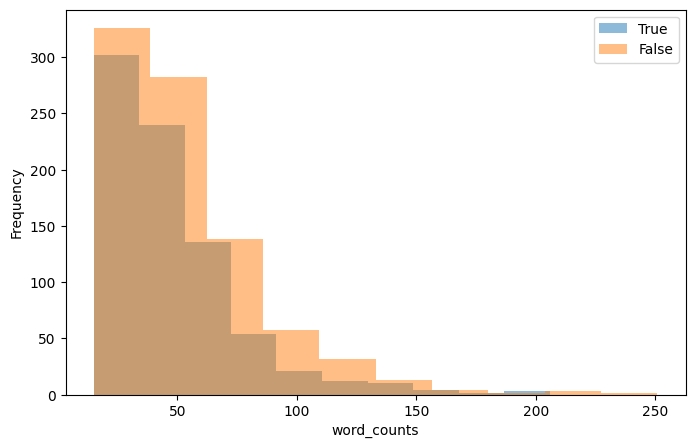

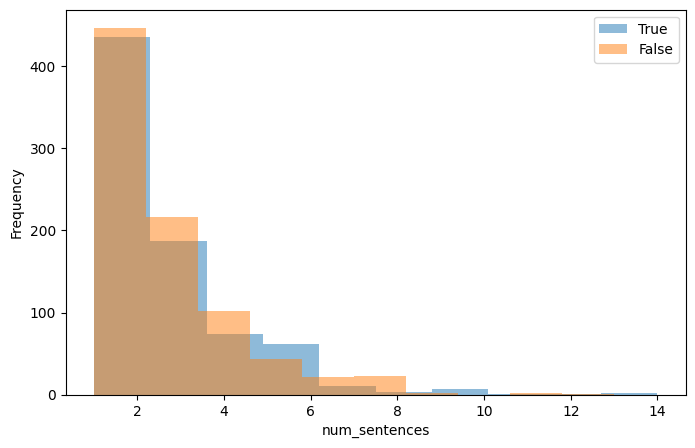

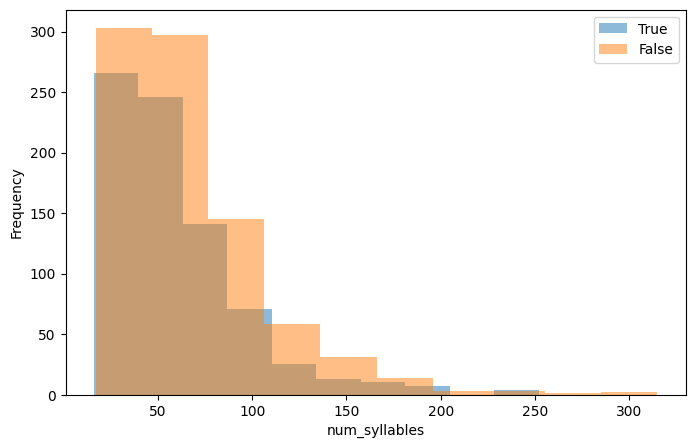

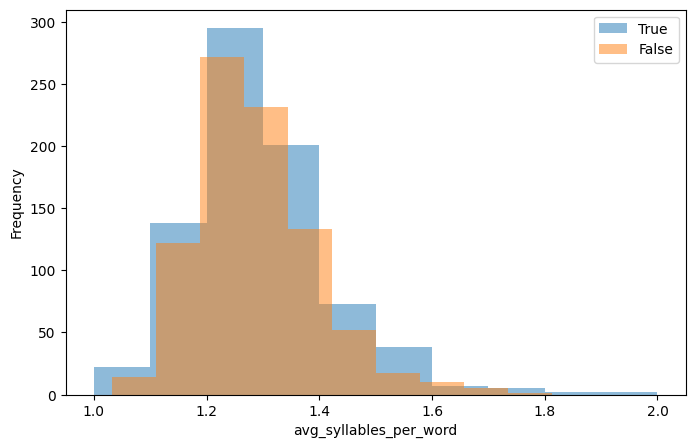

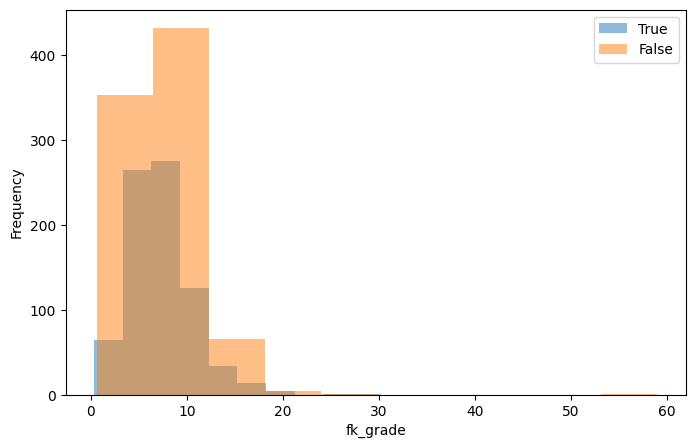

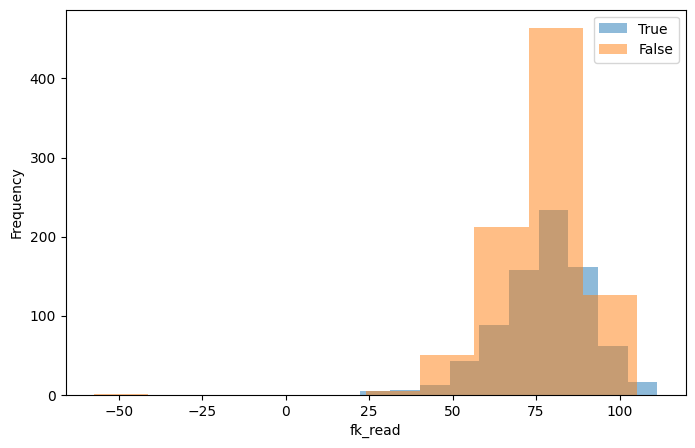

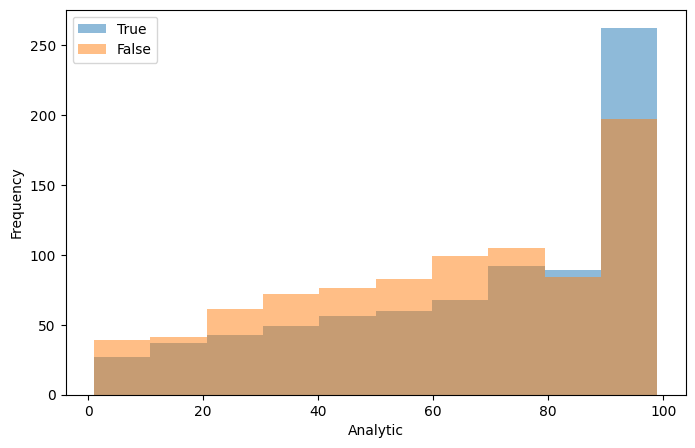

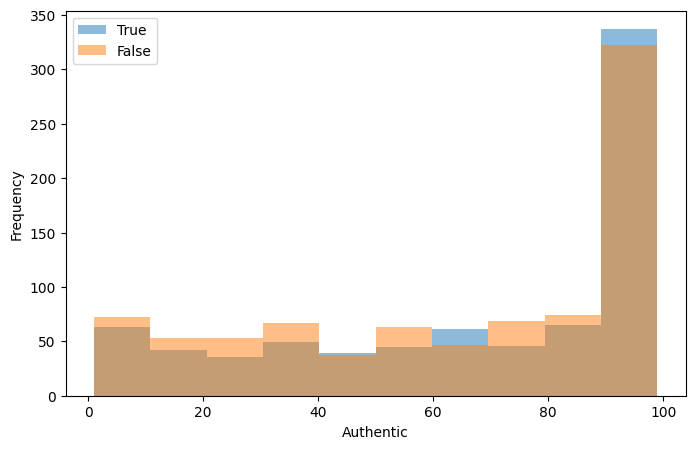

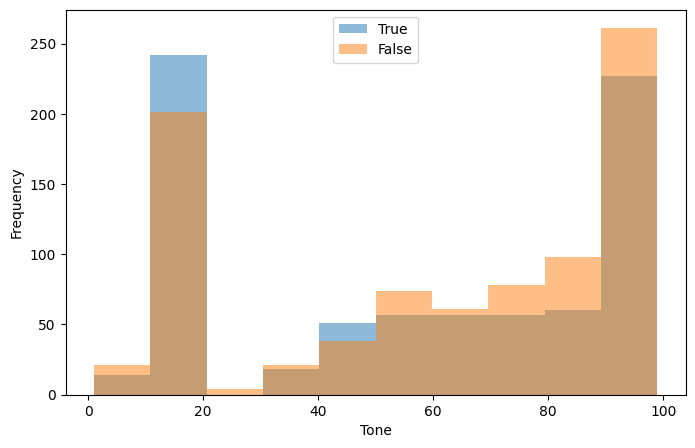

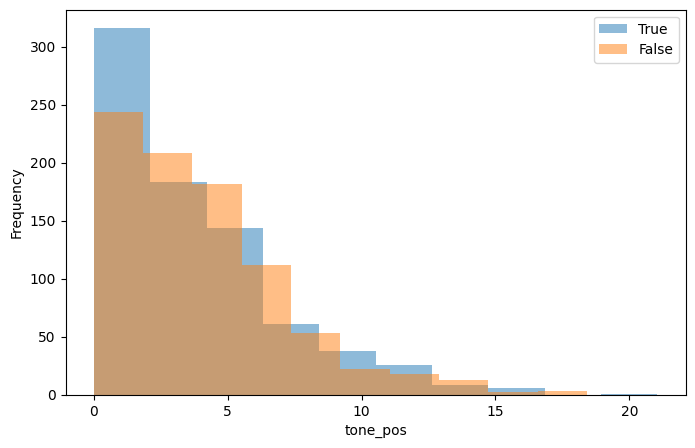

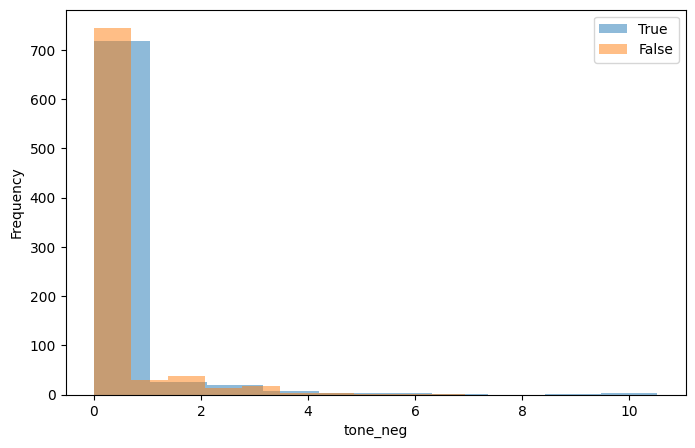

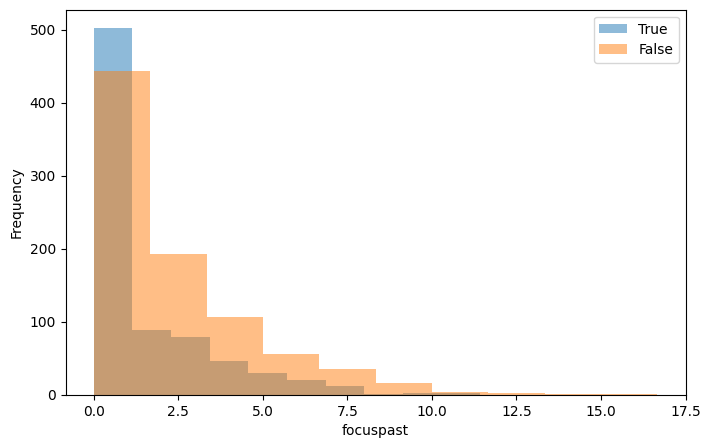

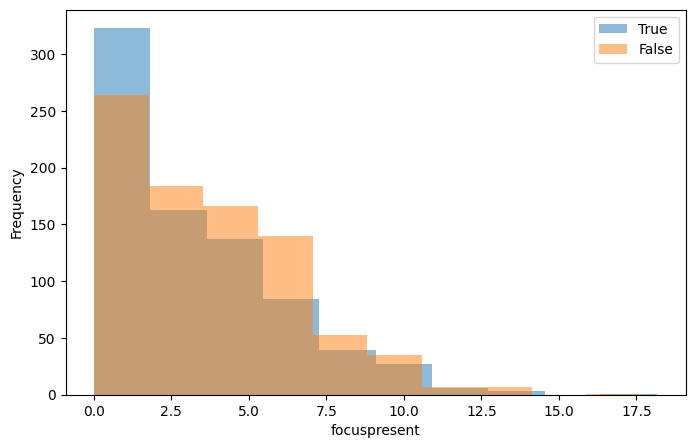

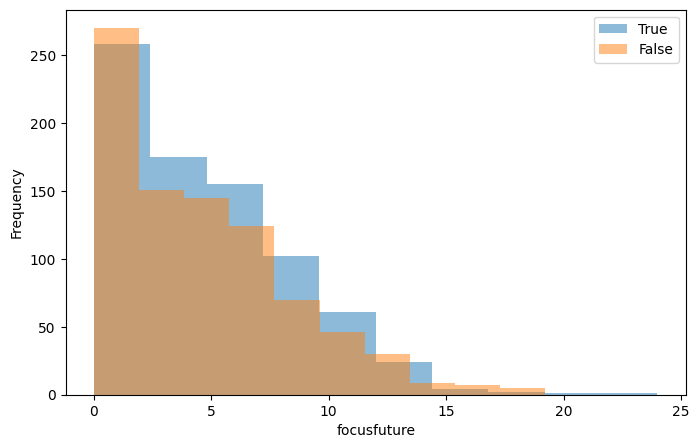

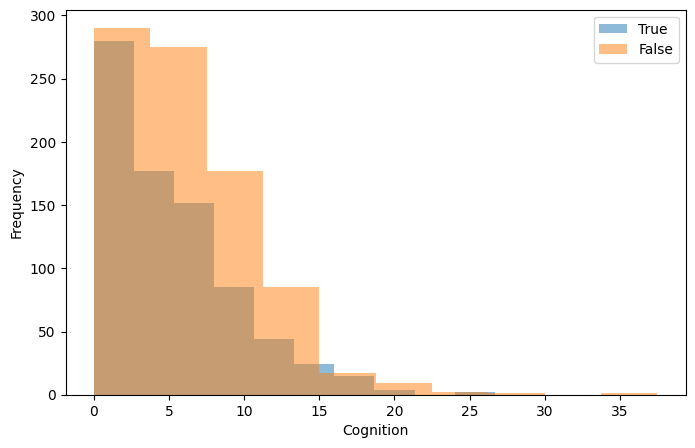

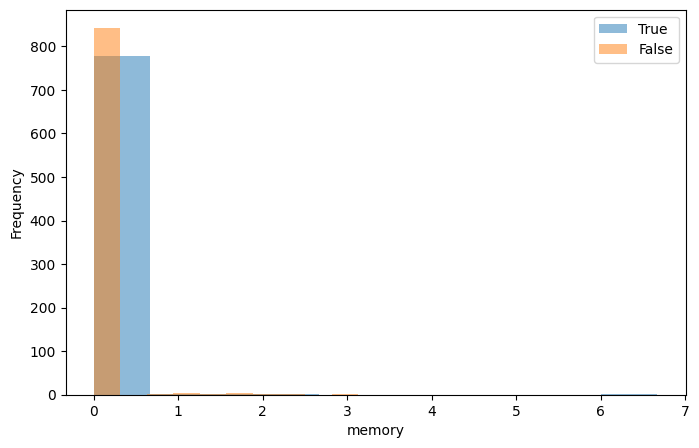

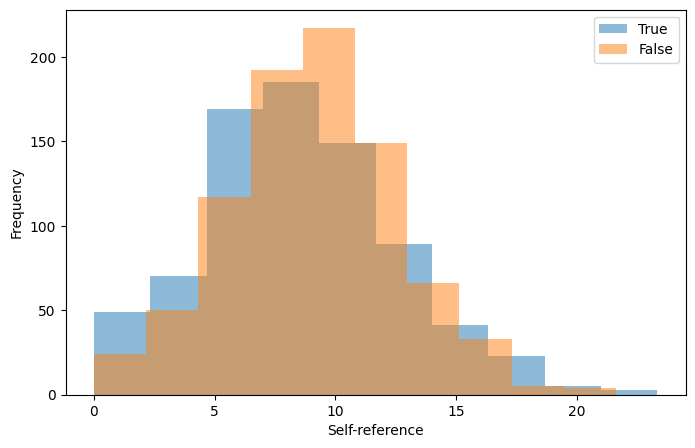

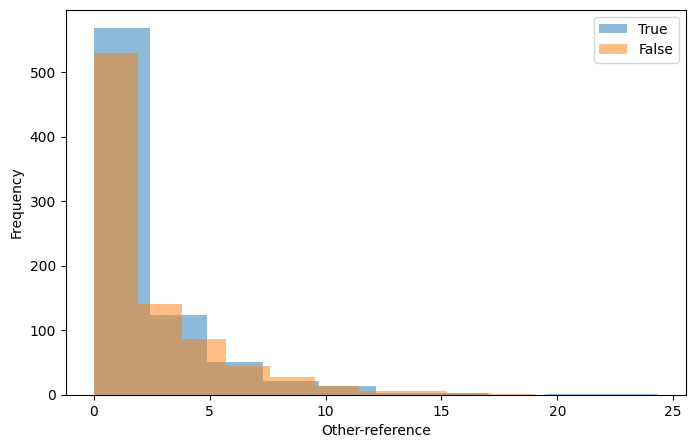

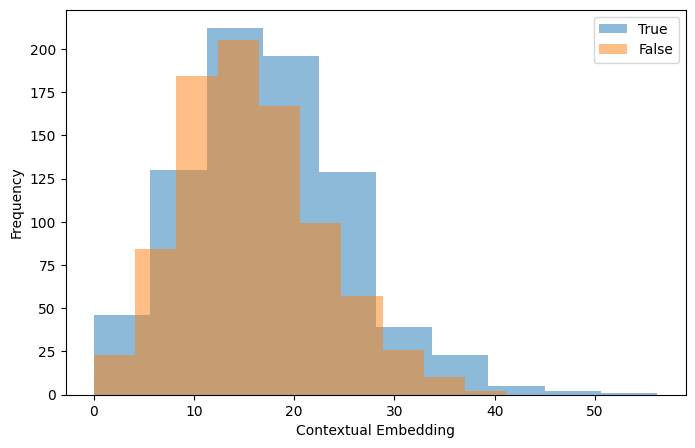

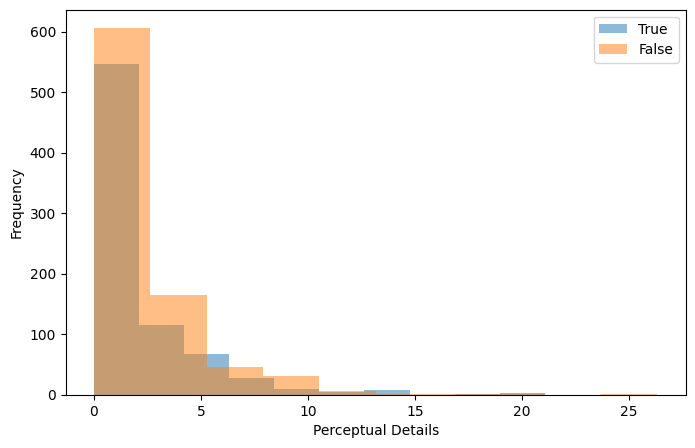

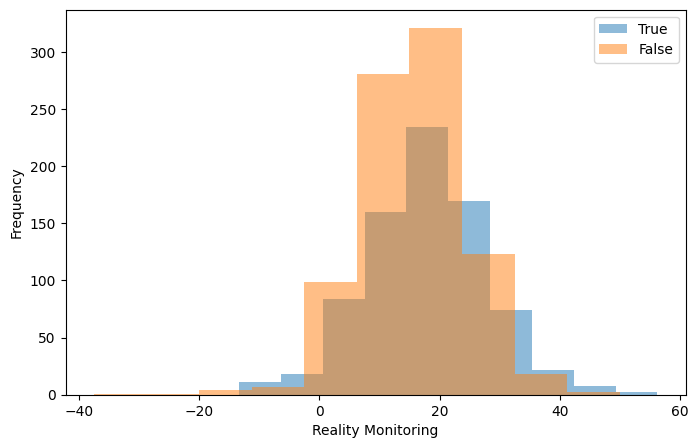

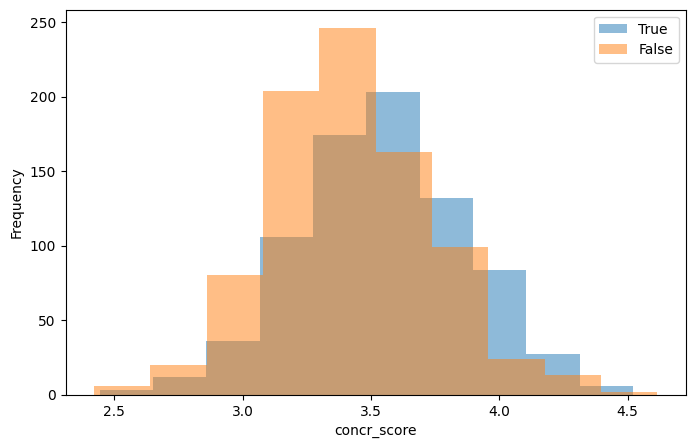

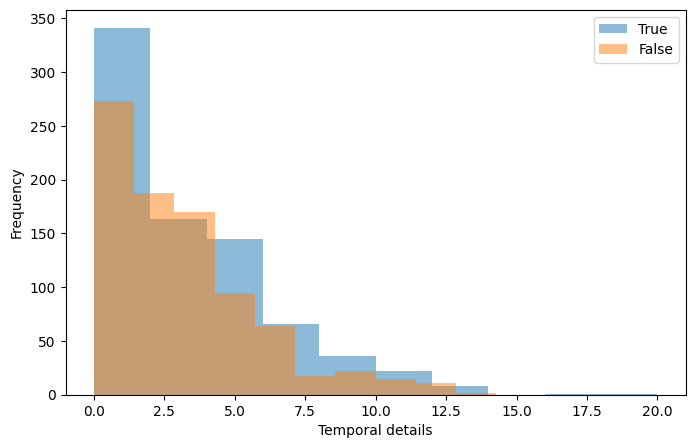

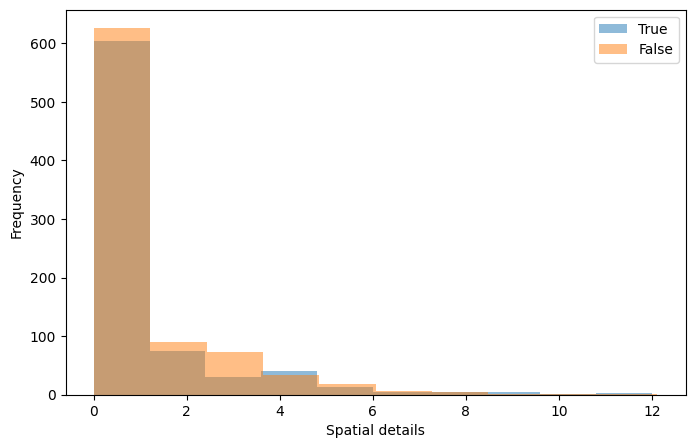

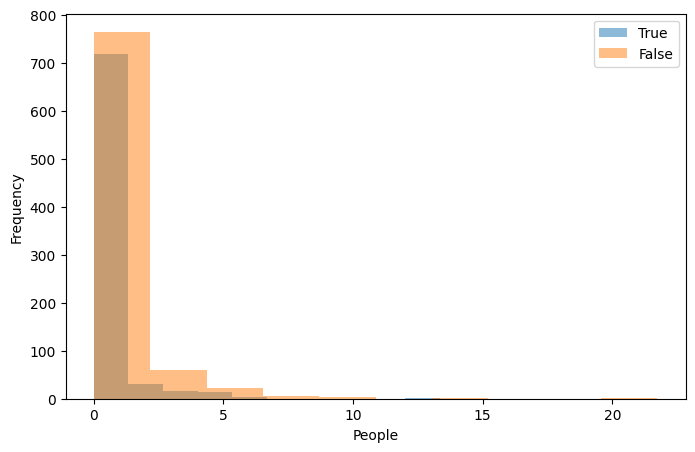

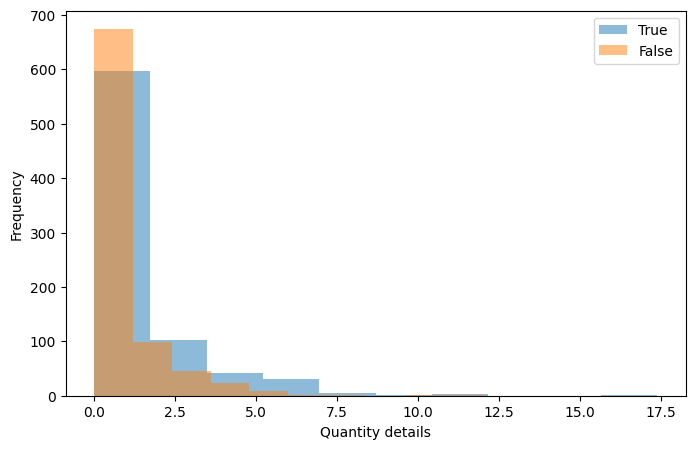

In [45]:
import matplotlib.pyplot as plt

# Plot histograms
for score in scoring_df_h:
    # Plot histogram for score in scoring_df_h
    scoring_df_h[score].plot.hist(alpha=0.5, figsize=(8, 5), bins=10, label = 'True')

    # Plot histogram for score in scoring_df_d
    scoring_df_d[score].plot.hist(alpha=0.5, figsize=(8, 5), bins=10, label = 'False')

    # Add labels to variables
    plt.xlabel(score)
    plt.ylabel('Frequency')
    plt.legend()

    # Show plot
    plt.show()


Boxplot

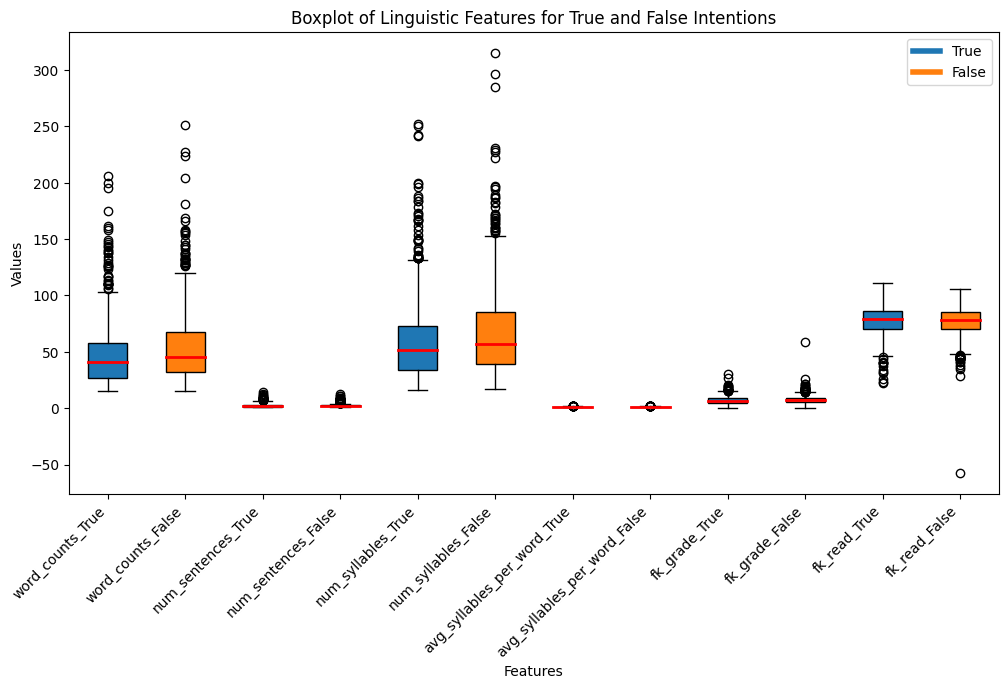

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,1:7].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


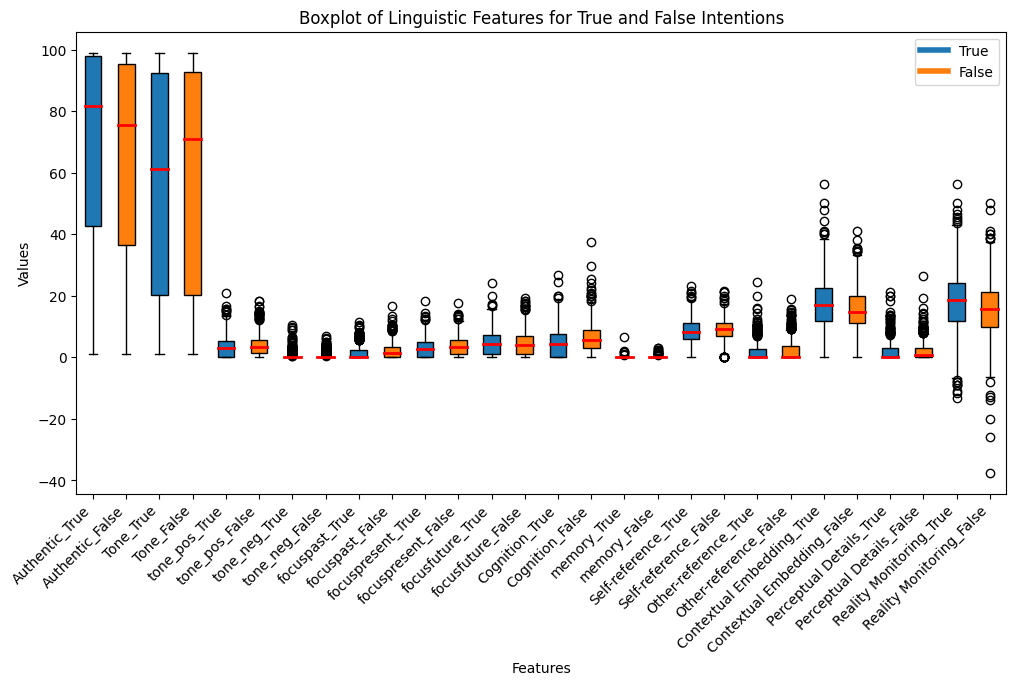

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,8:-5].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


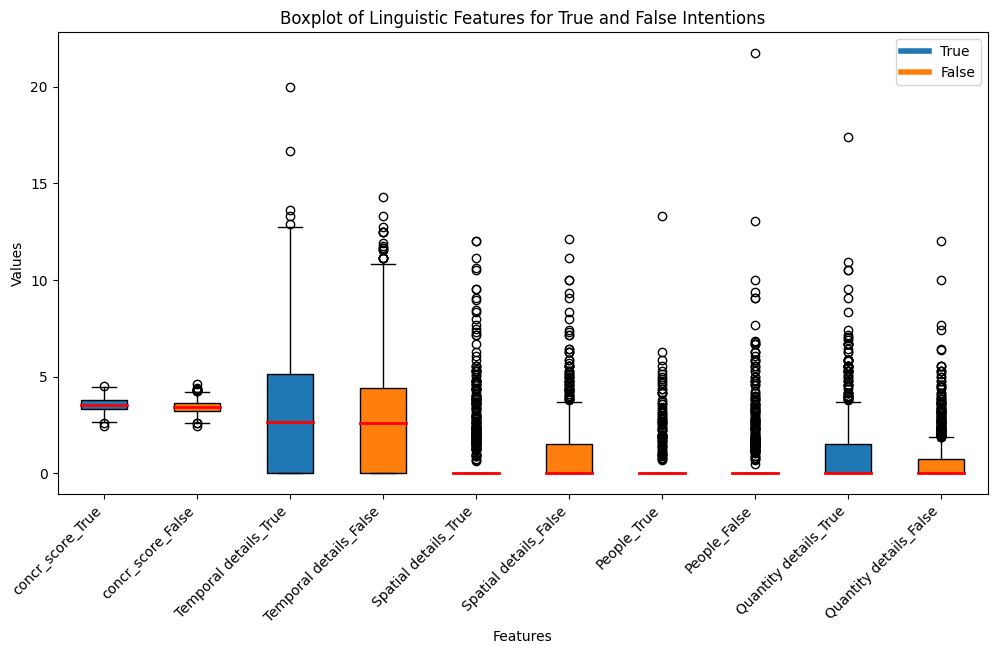

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,-5:].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


In [49]:
# Computing indipendent permutation tests:

def statistic(x, y, axis):
  return np.mean(x, axis=axis) - np.mean(y, axis=axis)


stats = []
p_values = []
cles_scores = []

for col in scoring_df_h.columns:
    # stats and p-value:
    res = permutation_test((scoring_df_h[col], scoring_df_d[col]), statistic, vectorized=True, n_resamples=10000)
    stats.append(res.statistic)
    p_values.append(res.pvalue)
    # effect size:
    cles = pg.compute_effsize(scoring_df_h[col], scoring_df_d[col], eftype='CLES')
    cles_scores.append(cles)

# perform multiple comparisons correction using Bonferroni method
null_h_rej, corrected_p_values, _, _ = multipletests(p_values, alpha = 0.05, method='holm')

# save results in a dataframe
perm_df = pd.DataFrame({"feature": scoring_df_h.columns, "stat": stats, "p_value": p_values, "corrected_p_value": corrected_p_values, "effect_size":cles_scores, "null_h_rejected": null_h_rej})
perm_df["significance"] = ['*' if null_h == True else '-' for null_h in perm_df['null_h_rejected']]

# print all comparisons
perm_df.sort_values(["null_h_rejected","effect_size"], ascending=False, inplace=True)
perm_df

,feature,stat,p_value,corrected_p_value,effect_size,null_h_rejected,significance
21,concr_score,0.124834,0.000200,0.005199,0.613113,True,*
20,Reality Monitoring,2.474178,0.000200,0.005199,0.575353,True,*
6,Analytic,5.859154,0.000200,0.005199,0.567668,True,*
18,Contextual Embedding,1.839548,0.000200,0.005199,0.564916,True,*
25,Quantity details,0.351607,0.000400,0.006399,0.529715,True,*
16,Self-reference,-0.572305,0.002800,0.041996,0.450522,True,*
24,People,-0.335172,0.000200,0.005199,0.450358,True,*
2,num_syllables,-7.499870,0.000200,0.005199,0.437335,True,*
12,focuspresent,-0.605411,0.000200,0.005199,0.435051,True,*
0,word_counts,-6.508944,0.000200,0.005199,0.430483,True,*


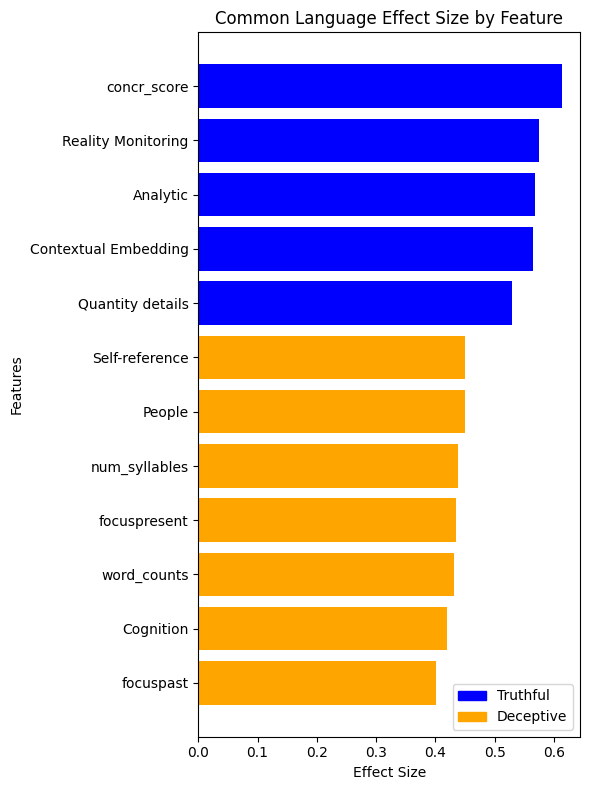

In [50]:
import matplotlib.pyplot as plt

# Select only significant features
perm_df_selected = perm_df.loc[perm_df['null_h_rejected'] == True, :]

# Sort the dataframe by effect size in descending order
perm_df_sorted = perm_df_selected.sort_values("effect_size", ascending=True)

# Create a horizontal bar chart of effect size with an increased figure size
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust the size (width, height) as needed

# Define colors based on the stat value
colors = ['blue' if stat > 0 else 'orange' for stat in perm_df_sorted['stat']]

# Plot the bars
bars = ax.barh(perm_df_sorted['feature'], perm_df_sorted['effect_size'], color=colors)

# Add legend
t_patch = plt.Rectangle((0, 0), 0, 0, color='blue', label='Truthful')
f_patch = plt.Rectangle((0, 0), 0, 0, color='orange', label='Deceptive')
plt.legend(handles=[t_patch, f_patch])

# Set labels
ax.set_xlabel('Effect Size')
ax.set_ylabel('Features')
ax.set_title('Common Language Effect Size by Feature')

# Show the plot
plt.tight_layout()
plt.show()
